## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.


Total number of car images: 8792
Total number of non-car images: 8968 



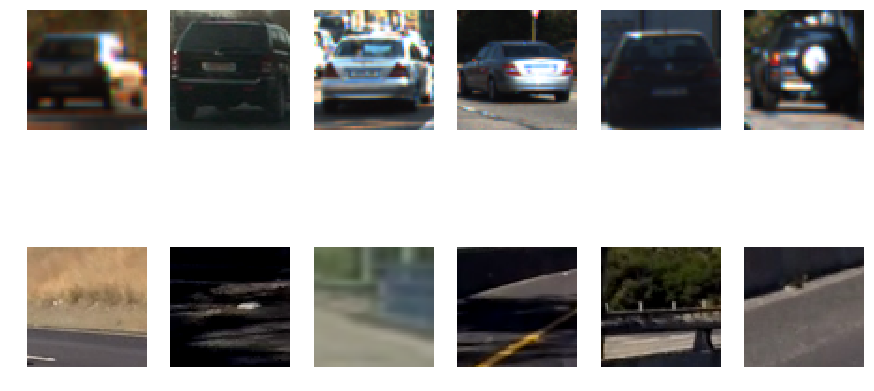

Car images shape: (64, 64, 3)
Not-car images shape: (64, 64, 3)
Images type: float32


In [1]:
# Vehicle Detection Project
# Author: Jelena Kocic
# Date: 23.04.2017.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random

car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print ("Total number of car images: %d\nTotal number of non-car images: %d \n" %(len(car_images),len(noncar_images)))


plt.figure(figsize=(15,8))

for i in range(6):
    car_ind = np.random.randint(0, len(car_images))
    notcar_ind = np.random.randint(0, len(noncar_images))
    
    car_image = mpimg.imread(car_images[car_ind])
    notcar_image = mpimg.imread(noncar_images[notcar_ind])

    plt.subplot(2,6,i+1)
    plt.imshow(car_image)
    plt.axis('off')
    plt.subplot(2,6,6+i+1)
    plt.imshow(notcar_image)
    plt.axis('off')

plt.show()


print('Car images shape:', car_image.shape)
print('Not-car images shape:', notcar_image.shape)
print('Images type:', car_image.dtype)


# Histogram of Oriented Gradients (HOG)

In [2]:
#Extract HOG features just once for the entire region of interest in each full image / video frame 
#(i.e. lower half of each frame of video) and subsample that array for each sliding window 
#by applying skimage.feature.hog() with the flag feature_vec=False

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)

        return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,bin_feature='Disabled',color_feature='Disabled'):
    import matplotlib.image as mpimg
    # Create a list to append feature vectors to
    features = []
    m_features=[]
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         features.append(hog_features)
        
        bin_features = []
        bin_features = bin_spatial (feature_image, size=(64, 64)).ravel()  
        
        color_features = []
        color_features = color_hist(feature_image, nbins=32).ravel() 
        
        if (bin_feature=='Enabled' and color_feature =='Enabled'): 
            m_features.append (np.hstack((bin_features,hog_features)))
            
        elif (color_feature == 'Enabled'): 
            m_features.append (np.hstack((color_features,hog_features,)))

        elif (bin_feature == 'Enabled'):
            m_features.append (np.hstack((bin_features,hog_features,color_features)))
        else:
            m_features.append (hog_features)
            
    return m_features

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification

# Define a single function that can extract features using hog sub-sampling and make predictions

def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,bin_feature='Disabled',color_feature='Disabled'):

    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
      
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False) 
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            if ((bin_feature == 'Enabled') or (color_feature == 'Enabled')):
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                if bin_feature=='Enabled' and color_feature =='Enabled': 
                    bin_features = bin_spatial(subimg, size=spatial_size)
                    color_features = bin_spatial(subimg, size=spatial_size)
                    X = np.hstack((bin_features, color_features, hog_features)).reshape(1, -1).astype(np.float64)
            
                elif color_feature == 'Enabled': 
                    color_features = bin_spatial(subimg, size=spatial_size)
                    X = np.hstack((color_features, hog_features)).reshape(1, -1).astype(np.float64)
                else:
                    bin_features = bin_spatial(subimg, size=spatial_size)
                    X = np.hstack((bin_features, hog_features)).reshape(1, -1).astype(np.float64)
            else: 
                #print("test")
                X  = hog_features.reshape(1, -1)
                            
            #min_X = X.min()
            #max_X = X.max()
            #test_features = X - X.max() / (X.max() - X.min()) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            test_features = X_scaler.transform(X)
            test_prediction = svc.predict( X )
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
	

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
	
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
	
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

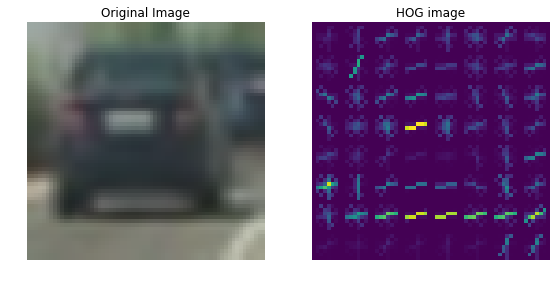

In [3]:
global colorspace 
global hog_channel
global orient 
global pix_per_cell
global cell_per_block

colorspace= 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient= 9 
pix_per_cell = 8 
cell_per_block =2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


hog_rand_img = mpimg.imread(car_images[0])
features, hog_image = get_hog_features(hog_rand_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.figure(figsize=(40,40))
plt.subplot(181)
plt.title('Original Image')
plt.imshow(hog_rand_img)
plt.axis('off')
plt.subplot(182)
plt.title('HOG image')
plt.imshow(hog_image)
plt.axis('off')

plt.show()

In [4]:
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
           

In [5]:
# Number of Feature Extracted
print ("Total Number of Feature used in a model :" , len(car_features[0]))


# Shuffle and Split the data into training and test data
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


Total Number of Feature used in a model : 5292


In [6]:
# linear Support Vector Classfier to classify the image

from sklearn.svm import SVC

svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

40.55 Seconds to train SVC
Test Accuracy of SVC =  0.984



# Sliding Window Search

In [9]:
def draw_img(img):
    rectangles=[]
    
    ystart = 400
    ystop = 660
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 660
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    
    ystart = 400
    ystop = 660
    scale = 2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))



    
    rectangles = [item for sublist in rectangles for item in sublist] 
    draw_img = draw_boxes(np.copy(img), rectangles, thick=2)    
    return (draw_img,rectangles)

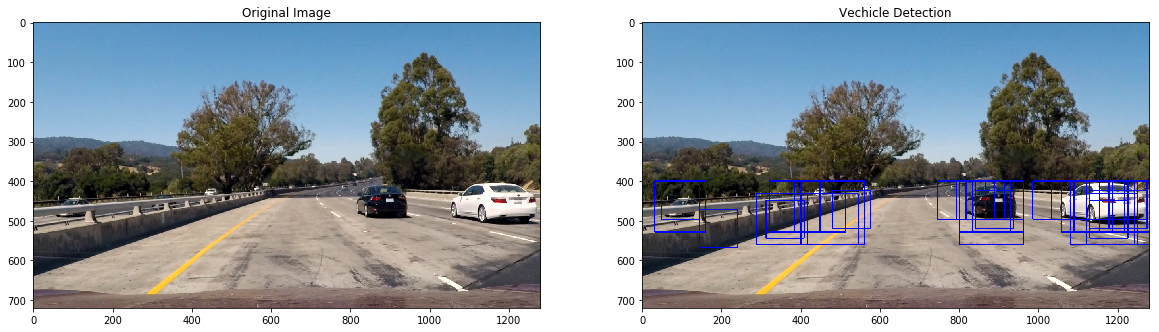

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image')
test_img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(test_img)
plt.subplot(122)
plt.title('Vechicle Detection')
draw_box,rectangles= draw_img(test_img)
plt.imshow(draw_box)
plt.show()

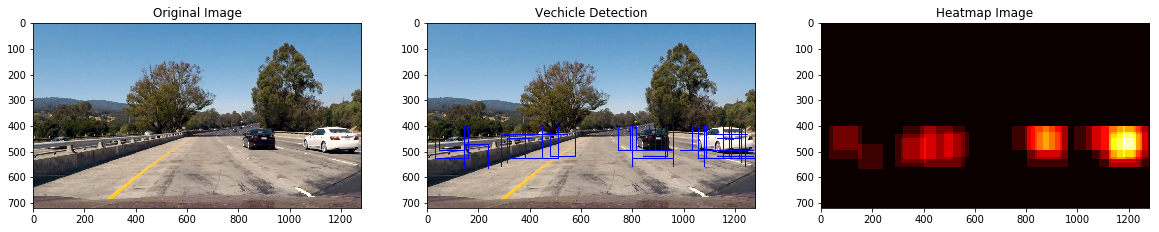

In [11]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('Vechicle Detection')
plt.imshow(draw_box)
plt.subplot(133)
plt.title('Heatmap Image')
plt.imshow(heatmap_img, cmap='hot')
plt.show()

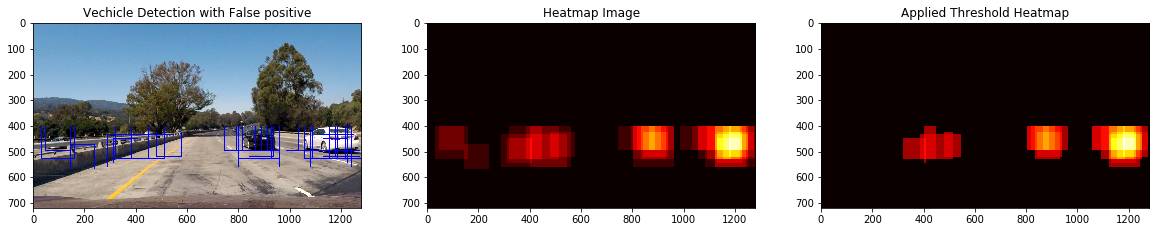

In [12]:
threshold_heatmap_img = apply_threshold(np.copy(heatmap_img),2)
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Vechicle Detection with False positive')
plt.imshow(draw_box)
plt.subplot(132)
plt.title('Heatmap Image')
plt.imshow(heatmap_img, cmap='hot')
plt.subplot(133)
plt.title('Applied Threshold Heatmap')
plt.imshow(threshold_heatmap_img, cmap='hot')
plt.show()

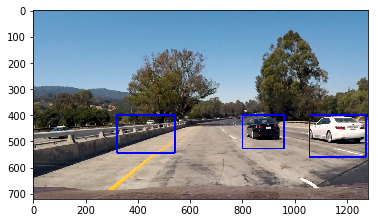

In [13]:
labels = label(threshold_heatmap_img)

draw_img, rects = draw_labeled_bboxes(np.copy(test_img), labels)
plt.imshow (draw_img)
plt.show()

In [14]:
def pipeline_image(img):
    
    rectangles=[]


    
    ystart = 400
    ystop = 660
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 660
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 660
    scale = 2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [15]:
# Define a class to store data from video
## This logic is taken from Harish Vadlamani 

class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

# Video Implementation

In [16]:
# Videom Srim Pipeline

det = Vehicle_Detect()
from moviepy.editor import VideoFileClip
proj_out_file = 'project_video_output.mp4'
clip_proj = VideoFileClip('project_video.mp4') 
clip_proj_out = clip_proj.fl_image(pipeline_image)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:54<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 55s
